# Compare simulation and mean field for Potjans' model


In [70]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)

%matplotlib inline

save_fig = True
figure_path = os.path.join(".", "figures")
reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)

colors = style.colors

## Mean field model

In [72]:
# %load "../analysis/trans_mean_field.py"
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root

    if jacobian==False:
        jac = False
    else:
        print("Use jacobian")
        jac = model.jacobian
        
    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        v0  = sol["x"]
        if np.all(v0 < 1./model.t_ref): 
            return v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")
        
def CV_ISI_mf(v0, model=model_class.model()):
    """Coefficient of variation of interspike interval as predicted by Brunel
    """
    from scipy.integrate import dblquad
    from scipy.special import erf, erfcx
    mu     = model.mu(v0)
    sd     = model.sd(v0)
    lows   = (model.V_r - mu) / sd
    ups    = (model.theta - mu) / sd
    bounds = np.array([lows, ups]).T

    # Double integral
    def func(u, x):
        return np.exp(x**2) * np.exp(-u**2) * erfcx(-u)**2
    gfun = lambda x: -np.inf
    hfun = lambda x: x
    dbl_integral  = np.array([dblquad(func, low, up, gfun, hfun, epsabs=1.49e-08, epsrel=1.49e-08)[0]
                                   for low, up in bounds])

    cv_theo = np.sqrt(2 * np.pi * v0**2 * dbl_integral * model.tau_m**2) # Define as sd / mean, NOT var / mean**2
    return cv_theo

In [69]:
from scipy.special import erf, erfcx
f = lambda u: np.exp(u**2) * (1. + erf(u))
xs = np.array([-10, -6, -4, 0, 4, 6, 10])

np.set_printoptions(precision=2, suppress=True)
print(f(xs))
print( erfcx(-xs))

[  0.00e+00   0.00e+00   1.37e-01   1.00e+00   1.78e+07   8.62e+15
   5.38e+43]
[  5.61e-02   9.28e-02   1.37e-01   1.00e+00   1.78e+07   8.62e+15
   5.38e+43]


In [64]:
def plot_compare_sim_mf(data_sim, data_mf, ax):
    y_mf = np.arange(n_populations) + 0.1
    yticks = np.arange(n_populations) + 0.5
    if reverse_order:
        y_mf = y_mf[::-1]
        yticks = yticks[::-1]
    bar_height = 0.8 

    for i, population in enumerate(populations):
        ax.plot(data_sim[:, i], [yticks[i]]*rates_mean_all.shape[0], '+', color=colors[i], mew=0.7, ms=style.cross_size)
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                color=colors[i], linewidth=0, fill=True, alpha=0.4) 
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                edgecolor=colors[i], linewidth=1, fill=False, alpha=1.0) 
    ax.barh([0], [0], color="lightgray", edgecolor="darkgray", linewidth=2, fill=True, alpha=1.0, label="mean field") 
    ax.plot([-1], [0], "+", color="gray", alpha=1.0, label="simulated", mew=1., ms=style.cross_size / style.legend_ms) 

    yticklabels = hf.rlbl(populations)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

## With connection_rule = "fixed_total_number":

Use jacobian
Integration time: 0.10
CV calc time: 0.46


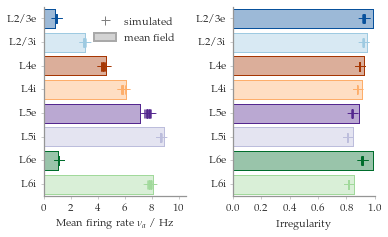

In [65]:
######################################################
# Mean field results
######################################################

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
weight_rel_sd   = 0.1
model_micro     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 

v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
jacobian=True
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

t_int0      = time.time()
rate_mf     = solve_model(model_micro, v_guess_0,
                          jacobian=jacobian,
                          root_method=root_method, options=options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

t_int0      = time.time()
cv_isi_mf   = CV_ISI_mf(rate_mf, model=model_micro)
t_int1      = time.time() - t_int0
print("CV calc time: %.2f"%(t_int1))


######################################################
# Simulation results
######################################################
# DATA
sim_spec = "spon_act_statistic"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all  = np.zeros((n_sims, n_populations))
    cv_isi_mean_all = np.zeros((n_sims, n_populations))
    synchrony_all   = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"][:]
        cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]
        synchrony_all[j]    = res_grp["synchrony"][:]
        
######################################################
# Plotting
######################################################

fig = plt.figure()
fig.set_size_inches(*style.figsize) 

ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_compare_sim_mf(rates_mean_all, rate_mf, ax1)
ax1.set_xlabel("Mean firing rate $\\nu_a$ / Hz")
ax1.set_xlim(0, 10.5)
ax1.legend(loc="best")
    
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)
plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2)
ax2.set_xlabel("Irregularity")
ax2.set_xlim(0, 1)

for ax in fig.axes:
    style.fixticks(ax)

fig_name = "compare_sim_mf_fixed_total_number"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

## Print numerical results: Rates and CV of ISI (for latex)

In [6]:
def print_line(data, max_i=2):
    dstr = ""
    for d in data:
        if abs(d) < 0.01:
            dstr += "& %.e"%d
            dstr = dstr[:-2] + dstr[-1]
        else:
            dstr += ("& {0:%i.%if} "%(max_i + 4, max_i)).format(d)

    dstr += r"\tn[0.2cm]"
    return dstr

tabstr = ""
   
# Firing rates
r_mf = rate_mf   # Mean field rate
r_sim = np.mean(rates_mean_all, axis=0)   # Simulation rate
drs = (r_mf - r_sim) # Absolute deviation for rates
rdrs = drs / r_sim # Relative deviation for rates
labels = [
    r"$ \nu_{\text{mf}, a}$ / Hz",
    r"$ \nu_{\text{sim}, a}$ / Hz",
    r"$\Delta \nu_a$ / Hz",
    r"$\Delta \nu_a / \nu_{\text{sim}, a}$"
]
for data, label in zip((r_mf, r_sim, drs, rdrs), labels):
    tabstr += label  + "\n    "
    tabstr += print_line(data, max_i=2)  + "\n"
   
mean_str_rate = "$({0:4.2f} \\pm {1:4.2f})$ Hz".format(np.mean(abs(drs)), np.std(abs(drs)))

# CV of ISI
cv_mf = cv_isi_mf 
cv_sim = np.mean(cv_isi_mean_all, axis=0)
dcv = (cv_mf - cv_sim)  # Absolute deviation for rates
rdcv = dcv / cv_sim # Relative deviation for rates
labels = [
    r"$ \text{CV}_{\text{mf}, a}$",
    r"$ \text{CV}_{\text{sim}, a}$",
    r"$\Delta \text{CV}_a$",
    r"$\Delta \text{CV}_a / \text{CV}_{\text{sim}, a}$"
]
for data, label in zip((cv_mf, cv_sim, dcv, rdcv), labels):
    tabstr += label  + "\n    "
    tabstr += print_line(data, max_i=2)  + "\n"

print(tabstr)

mean_str = "$({0:4.2f} \\pm {1:4.2f})$".format(np.mean(abs(dcv)), np.std(abs(dcv)))
proz_str = "$({0:d} \\pm {1:d})$".format(int(np.mean(abs(dcv)) / np.mean(cv_sim) * 100), 
                                       int(np.std(abs(dcv)) / np.mean(cv_sim) * 100))



print(mean_str_rate)
print("\n")
print(mean_str)
print(proz_str)

$ \nu_{\text{mf}, a}$ / Hz
    &   0.82 &   3.02 &   4.64 &   6.12 &   7.14 &   8.92 &   1.04 &   8.09 \tn[0.2cm]
$ \nu_{\text{sim}, a}$ / Hz
    &   0.92 &   3.00 &   4.40 &   5.84 &   7.70 &   8.65 &   1.10 &   7.84 \tn[0.2cm]
$\Delta \nu_a$ / Hz
    &  -0.10 &   0.01 &   0.24 &   0.28 &  -0.56 &   0.27 &  -0.06 &   0.24 \tn[0.2cm]
$\Delta \nu_a / \nu_{\text{sim}, a}$
    &  -0.11 & 4e-3&   0.05 &   0.05 &  -0.07 &   0.03 &  -0.05 &   0.03 \tn[0.2cm]
$ \text{CV}_{\text{mf}, a}$
    &   0.99 &   0.94 &   0.92 &   0.91 &   0.89 &   0.84 &   0.99 &   0.85 \tn[0.2cm]
$ \text{CV}_{\text{sim}, a}$
    &   0.92 &   0.92 &   0.89 &   0.88 &   0.84 &   0.81 &   0.91 &   0.81 \tn[0.2cm]
$\Delta \text{CV}_a$
    &   0.07 &   0.03 &   0.03 &   0.03 &   0.05 &   0.04 &   0.08 &   0.04 \tn[0.2cm]
$\Delta \text{CV}_a / \text{CV}_{\text{sim}, a}$
    &   0.07 &   0.03 &   0.03 &   0.04 &   0.06 &   0.05 &   0.08 &   0.05 \tn[0.2cm]

$(0.22 \pm 0.16)$ Hz


$(0.04 \pm 0.02)$
$(5 \pm 2)$


(array([ 4.22348797,  3.26064097,  4.47523741,  2.52197922,  7.20709458,
         1.54285795,  1.67353431,  1.27777212]),
 array([ 0.40763013,  1.42170329,  2.12782152,  2.76011386,  3.1587064 ,
         3.70914971,  0.51566455,  3.39939241]),
 array([ 10.36107891,   2.29347501,   2.1032015 ,   0.91372289,
          2.28166017,   0.41596001,   3.24539336,   0.3758825 ]))

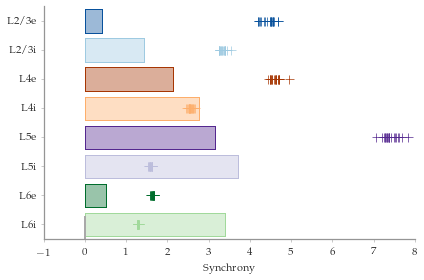

In [7]:

del_t = 3 * 1e-3 # s, time bin
synchrony_mf =  rate_mf * cv_isi_mf**2 / (1 + cv_isi_mf**2)

fig = plt.figure()

ax3 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_compare_sim_mf(synchrony_all, synchrony_mf, ax3)
ax3.set_xlabel("Synchrony")

for ax in fig.axes:
    style.fixticks(ax)
    
synchrony_all[0], synchrony_mf, synchrony_all[0] / synchrony_mf

## With connection_rule = "fixed_indegree" and different synapse model:

Integration time: 0.07
CV calc time: 0.52


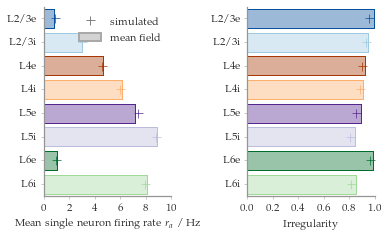

In [8]:
#sim_spec = "a1.0_t20.2_fixindeg_01"
sim_spec = "simulation_at_mf"
neuron_model    = "iaf_psc_delta"
connection_rule = "fixed_indegree"

######################################################
# Mean field results
######################################################

weight_rel_sd   = 0.1
model     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 

v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

t_int0      = time.time()
rate_mf     = solve_model(model, v_guess_0,
                          root_method=root_method, options=options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

t_int0      = time.time()
cv_isi_mf   = CV_ISI_mf(rate_mf, model=model)
t_int1      = time.time() - t_int0
print("CV calc time: %.2f"%(t_int1))


######################################################
# Simulation results
######################################################
# DATA

data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all = np.zeros((n_sims, n_populations))
    cv_isi_mean_all     = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"][:]
        cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]
        
######################################################
# Plotting
######################################################

fig = plt.figure()
fig.set_size_inches(*style.figsize) 

ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
plot_compare_sim_mf(rates_mean_all, rate_mf, ax1)
ax1.set_xlabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_xlim(0, 10)
ax1.legend(loc="best")
    
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)
data = cv_isi_mean_all
plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2)
ax2.set_xlabel("Irregularity")
ax2.set_xlim(0, 1)

for ax in fig.axes:
    style.fixticks(ax)

fig_name = "compare_sim_mf_fixed_indegree"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 

## Simulate changing $g$

In [17]:
# Data
sim_spec = "a1.0_t20.4_00"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)
(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

g_step      = 0.1
g_low       = 3 
g_up        = 10
n_low       = int((4 - g_low) / g_step) + 1
n_up        = int((g_up - 4) / g_step) + 1
n           = n_low + n_up
gs_low      = np.linspace(4, g_low, n_low, -1)
gs_up       = np.linspace(4, g_up, n_up)
gs          = np.concatenate((gs_low, gs_up), axis=0)
rates       = np.zeros((n, n_populations))
cv_isis     = np.zeros((n, n_populations))

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"

root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

for j, g in enumerate(gs):
    if g == 4:
        v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
    model_micro     = model_class.model(neuron_model=neuron_model,
                                        connection_rule=connection_rule, 
                                        g=g) 
    t_rate0      = time.time()
    rates[j]     = solve_model(model_micro, v_guess_0,
                              root_method=root_method, options=options)
    t_rate1      = time.time() - t_rate0
    t_cv0        = time.time()
    cv_isis[j]   = CV_ISI_mf(rate_mf, model=model_micro)
    t_cv1        = time.time() - t_cv0
    
    v_guess_0 = rates[j]
    #print("{0:2d}\t{1:6.2f}\t{2:8.2f} s\t{3:8.2f} s".format(j, g, t_rate1, t_cv1))


 0	  4.00	    0.07 s	1438094614.74
 1	  3.90	    0.03 s	1438094615.30
 2	  3.80	    0.03 s	1438094615.74
 3	  3.70	    0.03 s	1438094616.21
 4	  3.60	    0.03 s	1438094616.67
 5	  3.50	    0.03 s	1438094617.15
 6	  3.40	    0.03 s	1438094617.52
 7	  3.30	    0.03 s	1438094617.85
 8	  3.20	    0.03 s	1438094618.16
 9	  3.10	    0.03 s	1438094618.49
10	  3.00	    0.04 s	1438094618.88
11	  4.00	    0.07 s	1438094619.42
12	  4.10	    0.03 s	1438094619.99
13	  4.20	    0.03 s	1438094620.53
14	  4.30	    0.03 s	1438094621.08
15	  4.40	    0.03 s	1438094621.62
16	  4.50	    0.03 s	1438094622.16
17	  4.60	    0.03 s	1438094622.71
18	  4.70	    0.03 s	1438094623.26
19	  4.80	    0.03 s	1438094623.80
20	  4.90	    0.03 s	1438094624.35
21	  5.00	    0.03 s	1438094624.89
22	  5.10	    0.03 s	1438094625.43
23	  5.20	    0.03 s	1438094625.97
24	  5.30	    0.03 s	1438094626.51
25	  5.40	    0.03 s	1438094627.05
26	  5.50	    0.03 s	1438094627.59
27	  5.60	    0.03 s	1438094628.12
28	  5.70	    0.03 s

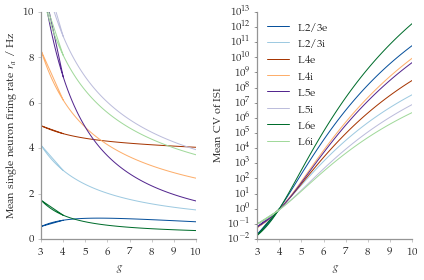

In [32]:
# Plotting
fig = plt.figure()
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

for i, population in enumerate(populations):
    ax1.plot(gs, rates[:, i], linestyle='-', color=colors[i],
        label=hf.rlbl(population))
    ax2.plot(gs, cv_isis[:, i], linestyle='-',  color=colors[i],
        label=hf.rlbl(population))
    
ax1.set_ylabel("Mean single neuron firing rate $r_a$ / Hz")
ax1.set_ylim(0, 10)

ax2.set_ylabel("CV of ISI")
ax2.set_yscale("log")
#ax2.set_ylim(ax2.get_ylim()[0], 100)
ax2.legend(loc="best")

for ax in fig.axes:
    ax.set_xlabel("$g$")
    style.fixticks(ax)